In [1]:
# import libraries
import os
import time
import sys
import pandas as pd
import numpy as np

from scipy.linalg import cholesky, eigvals
from scipy import stats
from scipy.optimize import minimize

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(r"C:\Users\WANGLIN CAI\fintech545")
import RiskManagement as RM

In [2]:
# change working directory
os.chdir(r'C:\Users\WANGLIN CAI\fintech545\Week05')

In [3]:
# q1
problem1 = pd.read_csv('problem1.csv')

In [4]:
problem1.head(5)

,x
0,-0.002665
1,-0.045128
2,0.053635
3,0.010450
4,-0.016284


In [5]:
def cal_VaR_ES_norm(returns, n=10000, alpha=0.05):
    # to get VaR, ES in one function
    
    # get basic stats
    mu = returns.mean()
    sigma = returns.std()
    simu_returns = np.random.normal(mu, sigma, n)
    simu_returns.sort()
    
    n = alpha * simu_returns.size
    
    # if n is not an interger, then:
    iup = int(np.ceil(n))
    idn = int(np.floor(n))
    VaR = (simu_returns[iup] + simu_returns[idn]) / 2

    ES = np.mean(simu_returns[0:idn])

    return -VaR, -ES, simu_returns

In [6]:
def MLE_t(params, returns):
    # provide parameters of df, mean and sd
    df, loc, scale = params
    
    # calculate log likelihood function
    neg_LL = -1 * np.sum(stats.t.logpdf(returns, df=df, loc=loc, scale=scale))
    return(neg_LL)


def cal_VaR_MLE_t(returns, n=10000, alpha=0.05):
    
    mu = returns.mean()[0]
    sigma = returns.std()[0]
    # add constraints to the optimizations
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - 1},
        {'type': 'ineq', 'fun': lambda x: x[2]}
    ]
    
    # optimization
    res = minimize(MLE_t, x0=[10.0, mu, sigma], args=(returns,), constraints=constraints)
    
    # get the optimized variables
    df, loc, scale = res.x
    print(df)
    # t distribution VaR, ES
    simu_returns = stats.t.rvs(df, loc=loc, scale=scale, size=n)
    simu_returns.sort()
    n = alpha * simu_returns.size
    iup = int(np.ceil(n))
    idn = int(np.floor(n))
    VaR = (simu_returns[iup] + simu_returns[idn]) / 2

    ES = np.mean(simu_returns[0:idn])

    return -VaR, -ES, simu_returns

In [7]:
VaR_norm, ES_norm, simu_norm = cal_VaR_ES_norm(problem1)
VaR_t, ES_t, simu_t = cal_VaR_MLE_t(problem1)
print("VaR_norm is {}".format(VaR_norm))
print("ES_norm is {}".format(ES_norm))
print("VaR_t is {}".format(VaR_t))
print("ES_t is {}".format(ES_t))

4.250997152846075
VaR_norm is 0.08062459749954634
ES_norm is 0.10220651176450801
VaR_t is 0.0751262441147022
ES_t is 0.11247629861546375


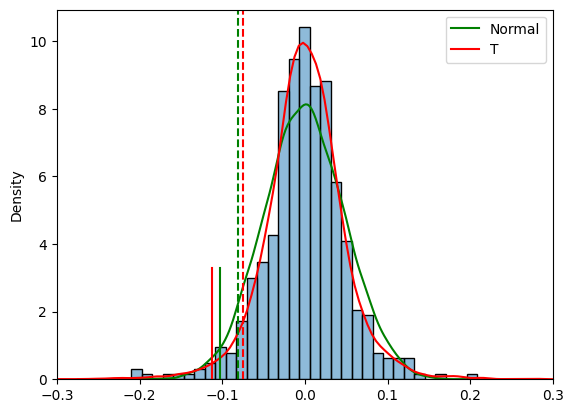

In [8]:
plt.figure()
norm_color = "green"
t_color = "red"

# plot histogram and 2 distributions PDFs
sns.histplot(problem1, stat="density")
sns.kdeplot(simu_norm, color=norm_color, label='Normal')
sns.kdeplot(simu_t, color=t_color, label='T')

# overlay the VaR and ES on existing plot
plt.axvline(- VaR_norm, color=norm_color, linestyle='--')
plt.axvline(- VaR_t, color=t_color, linestyle='--')
plt.axvline(- ES_norm, 0, 0.3, color=norm_color)
plt.axvline(- ES_t, 0, 0.3, color=t_color)

plt.xlim(-0.3, 0.3)
plt.legend()

plt.show()

In [9]:
# q2

In [10]:
DP = pd.read_csv("DailyPrices.csv")

# Calculate return
DP_return = RM.return_calculate(DP)
DP_return.drop('Date', axis=1, inplace=True)

C:\Users\WANGLIN CAI\fintech545\RiskManagement\return_calculate.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:,i]


In [11]:
# 1 covariance estimation techniques

In [12]:
ew_cov = RM.exp_weighted_cov(DP_return)
pd.DataFrame(ew_cov)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000155,0.000210,0.000235,0.000285,0.000279,0.000279,0.000284,0.000331,0.000368,0.000125,...,0.000172,0.000082,0.000052,0.000197,0.000042,0.000034,0.000171,0.000209,0.000160,0.000063
1,0.000210,0.000421,0.000321,0.000329,0.000526,0.000417,0.000417,0.000563,0.000527,0.000152,...,0.000182,0.000084,0.000039,0.000286,0.000087,0.000035,0.000222,0.000286,0.000201,0.000064
2,0.000235,0.000321,0.000499,0.000505,0.000438,0.000521,0.000529,0.000664,0.000610,0.000166,...,0.000220,0.000084,0.000042,0.000291,-0.000003,0.000032,0.000224,0.000297,0.000192,0.000038
3,0.000285,0.000329,0.000505,0.000939,0.000542,0.000657,0.000671,0.000923,0.000696,0.000200,...,0.000277,0.000128,0.000050,0.000336,-0.000115,-0.000016,0.000296,0.000436,0.000266,0.000039
4,0.000279,0.000526,0.000438,0.000542,0.002369,0.000434,0.000444,0.000636,0.001212,0.000119,...,0.000292,0.000079,0.000004,0.000381,0.000004,0.000066,0.000252,0.000666,0.000179,0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000034,0.000035,0.000032,-0.000016,0.000066,-0.000019,-0.000017,-0.000049,0.000013,0.000046,...,0.000048,0.000044,0.000033,0.000022,0.000087,0.000163,-0.000025,0.000052,-0.000003,0.000064
96,0.000171,0.000222,0.000224,0.000296,0.000252,0.000307,0.000307,0.000380,0.000468,0.000106,...,0.000168,0.000131,0.000194,0.000257,0.000034,-0.000025,0.000531,0.000186,0.000205,0.000082
97,0.000209,0.000286,0.000297,0.000436,0.000666,0.000325,0.000330,0.000615,0.000536,0.000165,...,0.000230,0.000097,0.000028,0.000250,0.000041,0.000052,0.000186,0.000716,0.000213,0.000064
98,0.000160,0.000201,0.000192,0.000266,0.000179,0.000279,0.000284,0.000361,0.000300,0.000142,...,0.000245,0.000092,0.000073,0.000186,0.000048,-0.000003,0.000205,0.000213,0.000325,0.000072


In [13]:
# 2 Non PSD fixes for correlation matrices

In [14]:
n = 500
sigma = np.full((n,n),0.9)
for i in range(n):
    sigma[i,i]=1.0
sigma[0,1] = 0.7357
sigma[1,0] = 0.7357

In [15]:
print("Sigma: ", RM.is_psd(sigma))
print("Sigma fixed with near_psd(): ", RM.is_psd(RM.near_PSD(sigma)))
print("Sigma fixed with Higham_psd(): ", RM.is_psd(RM.Higham(sigma)))

Sigma:  False
Sigma fixed with near_psd():  True
Sigma fixed with Higham_psd():  True


In [16]:
# 3 Simulation Methods

In [17]:
pd.DataFrame(np.cov(RM.direct_simulation(ew_cov).T))

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000157,0.000212,0.000236,0.000289,0.000282,0.000283,0.000288,0.000338,0.000371,0.000126,...,0.000173,0.000083,0.000053,0.000199,0.000043,0.000034,0.000174,0.000212,0.000163,0.000063
1,0.000212,0.000423,0.000324,0.000335,0.000529,0.000424,0.000423,0.000569,0.000529,0.000153,...,0.000185,0.000086,0.000041,0.000288,0.000088,0.000036,0.000226,0.000289,0.000205,0.000064
2,0.000236,0.000324,0.000502,0.000511,0.000438,0.000530,0.000538,0.000674,0.000609,0.000168,...,0.000222,0.000085,0.000043,0.000292,-0.000003,0.000033,0.000227,0.000298,0.000195,0.000038
3,0.000289,0.000335,0.000511,0.000948,0.000542,0.000669,0.000684,0.000944,0.000701,0.000204,...,0.000281,0.000132,0.000054,0.000340,-0.000114,-0.000014,0.000304,0.000439,0.000272,0.000040
4,0.000282,0.000529,0.000438,0.000542,0.002348,0.000443,0.000452,0.000635,0.001208,0.000119,...,0.000290,0.000082,0.000006,0.000387,0.000008,0.000069,0.000262,0.000663,0.000184,0.000077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000034,0.000036,0.000033,-0.000014,0.000069,-0.000018,-0.000015,-0.000048,0.000014,0.000046,...,0.000047,0.000043,0.000033,0.000023,0.000087,0.000163,-0.000024,0.000054,-0.000004,0.000065
96,0.000174,0.000226,0.000227,0.000304,0.000262,0.000313,0.000313,0.000386,0.000474,0.000108,...,0.000173,0.000135,0.000195,0.000260,0.000033,-0.000024,0.000538,0.000189,0.000211,0.000084
97,0.000212,0.000289,0.000298,0.000439,0.000663,0.000328,0.000333,0.000616,0.000537,0.000168,...,0.000232,0.000099,0.000030,0.000253,0.000047,0.000054,0.000189,0.000721,0.000217,0.000068
98,0.000163,0.000205,0.000195,0.000272,0.000184,0.000284,0.000290,0.000369,0.000307,0.000144,...,0.000248,0.000094,0.000074,0.000190,0.000048,-0.000004,0.000211,0.000217,0.000329,0.000072


In [18]:
pd.DataFrame(np.cov(RM.simulate_pca(ew_cov, 25000)))

Simulating with 100 PC Factors: 100.00% total variance explained


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000157,0.000212,0.000237,0.000289,0.000288,0.000283,0.000288,0.000336,0.000375,0.000126,...,0.000175,0.000084,0.000055,0.000200,0.000043,0.000034,0.000175,0.000212,0.000163,0.000064
1,0.000212,0.000422,0.000323,0.000332,0.000531,0.000423,0.000422,0.000571,0.000532,0.000154,...,0.000185,0.000085,0.000042,0.000289,0.000086,0.000035,0.000226,0.000288,0.000203,0.000064
2,0.000237,0.000323,0.000499,0.000507,0.000448,0.000527,0.000535,0.000671,0.000617,0.000167,...,0.000222,0.000086,0.000046,0.000295,-0.000002,0.000032,0.000232,0.000301,0.000197,0.000038
3,0.000289,0.000332,0.000507,0.000945,0.000561,0.000668,0.000683,0.000933,0.000709,0.000203,...,0.000284,0.000131,0.000056,0.000341,-0.000113,-0.000015,0.000306,0.000442,0.000273,0.000042
4,0.000288,0.000531,0.000448,0.000561,0.002368,0.000453,0.000463,0.000653,0.001224,0.000126,...,0.000305,0.000082,0.000013,0.000392,-0.000001,0.000067,0.000267,0.000674,0.000187,0.000080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000034,0.000035,0.000032,-0.000015,0.000067,-0.000020,-0.000017,-0.000051,0.000015,0.000047,...,0.000049,0.000044,0.000034,0.000025,0.000088,0.000164,-0.000024,0.000054,-0.000002,0.000065
96,0.000175,0.000226,0.000232,0.000306,0.000267,0.000315,0.000316,0.000390,0.000480,0.000107,...,0.000173,0.000135,0.000196,0.000261,0.000034,-0.000024,0.000538,0.000188,0.000208,0.000083
97,0.000212,0.000288,0.000301,0.000442,0.000674,0.000332,0.000337,0.000616,0.000541,0.000166,...,0.000235,0.000096,0.000032,0.000254,0.000041,0.000054,0.000188,0.000716,0.000217,0.000066
98,0.000163,0.000203,0.000197,0.000273,0.000187,0.000287,0.000292,0.000370,0.000305,0.000144,...,0.000249,0.000094,0.000074,0.000188,0.000048,-0.000002,0.000208,0.000217,0.000328,0.000073


In [19]:
#1. Pearson correlation and var
p_cov_var = RM.p_corr_var_f(problem1)
p_cov_var

array(0.00239253)

In [20]:
#2. Pearson correlation and EW variance
p_corr_ew_var = RM.p_corr_ew_var_f(problem1)
p_corr_ew_var

array([[0.00301315]])

In [21]:
#3. EW(cov+corr) is exp_weighted_cov(input, lambda_)
ew_corr_cov = RM.exp_weighted_cov(problem1)
ew_corr_cov

array([[0.00301315]])

In [22]:
#4. EW Corr +Var
ew_corr_p_var = RM.ew_corr_p_var_f(problem1)
ew_corr_p_var

array([[0.00238774]])

In [23]:
# 4/5 VaR and ES calculation methods

In [24]:
RM.cal_VaR_ES_norm(problem1)

(0.0801701797195414,
 0.10118919638373398,
 array([-0.18526643, -0.17391576, -0.1696489 , ...,  0.17157298,
         0.17488806,  0.20220341]))

In [25]:
RM.cal_VaR_ES_MLE_t(problem1)

(0.07851107644018746,
 0.11583688492893608,
 array([-0.44336944, -0.43078927, -0.36807035, ...,  0.30514986,
         0.35533626,  0.3556677 ]))

In [26]:
RM.cal_VaR_ES_AR1(problem1)

(0.0808619927437214,
 0.10121299672724171,
 array([-0.20113145, -0.18175945, -0.17689414, ...,  0.16910296,
         0.16975947,  0.17355202]))

In [27]:
weight = [1/problem1.shape[0] for number in problem1.index]
np.random.choice(a = problem1.index, size = 100, p = weight)


array([284,  55,  88, 395,  92,  13, 414, 341, 109, 447, 172, 371, 435,
       391, 121, 318,  94, 236, 145,  49, 398, 118, 408, 190, 475,  62,
       100, 250, 469, 153, 397, 290,  71,  54, 207, 113,  40, 341, 426,
       282,  25, 393, 196, 219, 394,  33, 321, 223, 326, 155, 484, 318,
        92, 441, 390, 366, 216, 198, 418,  82,  27, 487, 183, 398,  81,
        81, 119,  94, 142, 438, 342,  80,  69, 428, 336, 197, 209, 218,
       401, 410,  73, 216, 462, 299,  94, 495,   6, 336, 289, 312, 198,
       152, 492, 182, 133, 389, 192, 274, 421, 403], dtype=int64)

In [28]:
#simulated = RM.historical_simulation(problem1, DateOrNot='N')
#simulated.sort_values(by= simulated.columns[0])
RM.cal_VaR_ES_hist(problem1.values)

(array([0.07586151]),
 0.11677669788562187,
 [array([-0.20982718]),
  array([-0.20349812]),
  array([-0.19060988]),
  array([-0.16497177]),
  array([-0.1500457]),
  array([-0.1459249]),
  array([-0.13055459]),
  array([-0.1221129]),
  array([-0.11125093]),
  array([-0.11055212]),
  array([-0.1089988]),
  array([-0.10673401]),
  array([-0.10454729]),
  array([-0.09785949]),
  array([-0.09691663]),
  array([-0.09666577]),
  array([-0.09641942]),
  array([-0.08965954]),
  array([-0.08884503]),
  array([-0.08630644]),
  array([-0.08435787]),
  array([-0.083469]),
  array([-0.08236157]),
  array([-0.0786834]),
  array([-0.0782451]),
  array([-0.07586151]),
  array([-0.0751626]),
  array([-0.07430861]),
  array([-0.07276845]),
  array([-0.07225737]),
  array([-0.07199068]),
  array([-0.07049938]),
  array([-0.07039713]),
  array([-0.06928628]),
  array([-0.06909926]),
  array([-0.06861136]),
  array([-0.06802056]),
  array([-0.0678717]),
  array([-0.0674919]),
  array([-0.06728246]),
  array

In [29]:
portfolio = pd.read_csv("portfolio.csv")
DP = pd.read_csv("DailyPrices.csv")
Total_Value_A, assets_prices_A, holdings_A, delta_A = RM.get_single_portfolio(portfolio, DP, "A")

In [30]:
RM.cal_delta_VaR(Total_Value_A, assets_prices_A, delta_A)

5670.202920147335

In [31]:
RM.calculate_MC_var(assets_prices_A, holdings_A)

5620.179270962247

In [32]:
RM.cal_hist_VaR(assets_prices_A, holdings_A)

9138.87426422486

In [33]:
# q3

In [34]:
portfolio = pd.read_csv("portfolio.csv")
prices = pd.read_csv("DailyPrices.csv")

In [35]:
def fit_MLE_t(returns, n=10000, alpha=0.05):
    
    mu = returns.mean()
    sigma = returns.std()
    
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - 1},
        {'type': 'ineq', 'fun': lambda x: x[2]}
    ]
    
    res = minimize(MLE_t, x0=[10, mu, sigma], args=(returns,), constraints=constraints)
    
    df, loc, scale = res.x[0], res.x[1], res.x[2]
    return df, loc, scale

In [38]:
codes = ['A','B','C','all']

for code in codes:
    if code == 'all':
        Total_Value, assets_prices, holdings, delta = RM.get_all_portfolio(portfolio,prices)
    else:
        Total_Value, assets_prices, holdings, delta = RM.get_single_portfolio(portfolio,prices,code)
        
    assets_returns = RM.return_calculate(assets_prices)
    assets_returns.drop('Date', axis=1, inplace=True)
    norm_assets_returns = assets_returns - assets_returns.mean()

    # fit MLE t 
    parameters = []
    assets_returns_cdf = pd.DataFrame()
    for stock in norm_assets_returns.columns.tolist():
        this_return = norm_assets_returns[stock]
        params = fit_MLE_t(this_return)
        parameters.append(params)
    
        assets_returns_cdf[stock] = stats.t.cdf(norm_assets_returns[stock],df=params[0], loc=params[1], scale = params[2])
    spearman_corr_matrix = assets_returns_cdf.corr(method='spearman')
    simu_sample = RM.multivar_norm_simu(spearman_corr_matrix, method='pca')
    simu_sample = pd.DataFrame(simu_sample, columns=assets_returns.columns)

    simu_sample_cdf = pd.DataFrame()
    for stock in simu_sample.columns.tolist():
        simu_sample_cdf[stock] = stats.norm.cdf(simu_sample[stock],loc=0,scale=1)

    simu_returns = pd.DataFrame()
    for i, stock in enumerate(simu_sample.columns.tolist()):
        simu_returns[stock] = stats.t.ppf(simu_sample_cdf[stock], df=parameters[i][0], loc=parameters[i][1], scale = parameters[i][2])

    # Calculate the simulated prices
    assets_prices.drop('Date', axis=1, inplace=True)
    simu_prices = np.dot(simu_returns* assets_prices.tail(1).values.reshape(assets_prices.shape[1],),holdings)

    VaR_T, ES_T, ret = RM.cal_VaR_ES_hist(simu_prices)
    
    print("For Portfolio {}," .format(code))
    print("Total Value is {}".format(Total_Value))
    print("VaR is {}" .format(VaR_T))
    print("ES is {}" .format(ES_T))

For Portfolio A,
Total Value is 299950.05907389
VaR is 7976.406272430219
ES is 10517.464565591175
For Portfolio B,
Total Value is 294385.59081765
VaR is 6602.3430686198835
ES is 8741.83093723871
For Portfolio C,
Total Value is 270042.8305277
VaR is 5568.455505080508
ES is 7422.699784666997
For Portfolio all,
Total Value is 864378.48041924
VaR is 20127.49532727765
ES is 26276.86057677639


In [ ]:
def get_single_portfolio(portfolio, prices, portfolio_code):
    assets = portfolio[portfolio["Portfolio"] == portfolio_code]
        
    codes = list(assets["Stock"])
    assets_prices = prices[["Date"] + codes].copy()
    
    Total_Value = prices[codes].tail(1).values.dot(assets["Holding"].values)[0]
    holdings = assets["Holding"].values

    asset_values = holdings.reshape(-1, 1) * prices[codes].tail(1).T.values
    delta = asset_values / Total_Value
    
    return Total_Value, assets_prices, holdings, delta

Total_Value, assets_prices, holdings, delta =  get_single_portfolio(portfolio, prices, 'A')
assets_returns = RM.return_calculate(assets_prices)
assets_returns.drop('Date', axis=1, inplace=True)
norm_assets_returns = assets_returns - assets_returns.mean()

In [ ]:
parameters = []
assets_returns_cdf = pd.DataFrame()
for stock in norm_assets_returns.columns.tolist():
    this_return = norm_assets_returns[stock]
    params = fit_MLE_t(this_return)
    parameters.append(params)

    assets_returns_cdf[stock] = stats.t.cdf(norm_assets_returns[stock],df=params[0], loc=params[1], scale = params[2])
spearman_corr_matrix = assets_returns_cdf.corr(method='spearman')

In [ ]:
simu_sample = RM.multivar_norm_simu(spearman_corr_matrix, method='pca')
simu_sample = pd.DataFrame(simu_sample, columns=assets_returns.columns)
simu_sample


,AAPL,TSLA,JPM,HD,BAC,XOM,AVGO,PEP,TMO,CMCSA,...,SBUX,GE,ISRG,MU,NOW,ADP,PNC,ADI,SYK,TJX
0,-0.689669,-0.978556,-1.750263,-0.316323,-2.131343,0.788575,-0.612850,-0.233092,-1.031727,-1.515148,...,-1.074519,-0.892452,-0.294147,-1.269107,-1.734521,-0.603479,-3.554743,-0.804468,-1.431883,-1.469412
1,-0.671154,-0.272260,-0.672619,-2.603382,-0.594712,-0.200185,-1.094960,-1.921753,-0.156141,-0.884313,...,-0.414980,-0.213860,-0.527403,-0.473984,0.434726,-1.282278,-0.769952,-0.249343,-0.106698,-1.184277
2,0.376104,0.207117,-0.434449,0.775555,-0.067906,0.798533,0.096333,-0.862021,-0.932776,-1.096027,...,0.963049,-0.621958,-0.542922,-0.525608,0.025464,-0.732107,-0.663122,-0.727298,-0.828297,-0.490453
3,0.492821,1.992997,-0.549116,1.636812,0.359732,0.786604,0.470826,-0.202717,0.364759,0.871724,...,0.221903,0.985289,0.802833,0.768957,0.195471,0.766169,0.553699,0.432165,0.694054,1.177779
4,0.774937,-0.529540,-0.310863,0.963061,-0.549782,-0.152463,0.737186,-0.199836,0.330527,-0.175278,...,0.907122,-0.829698,1.122461,0.425125,-0.100711,0.613403,0.091852,0.114927,0.487714,-0.635491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.559747,-0.097678,1.549401,-1.085192,1.434269,-0.047230,0.526290,-0.359251,-0.190966,-0.400334,...,1.648553,1.231673,-0.179549,0.522292,0.019036,0.048123,0.784434,0.896202,0.765245,0.630216
24996,-2.264195,-0.955705,-1.893348,-1.973284,-2.056757,0.300044,-1.782250,-2.147022,-1.588200,-2.580636,...,-3.040422,-1.259252,-2.913350,-1.880601,-1.177440,-1.700094,-1.367702,-1.173671,-1.351295,-2.120023
24997,1.053834,0.844196,1.885257,2.394943,2.471418,0.307026,-0.120332,0.370724,1.900642,0.421782,...,2.199526,1.821171,1.585409,0.680994,0.969539,1.113314,1.917033,0.131593,2.578101,2.306815
24998,-0.446906,-0.088523,-0.819361,-1.071093,-0.565935,0.475989,-1.482509,-0.277355,-1.770333,-0.287354,...,-1.203694,-1.041059,-1.853709,-0.175657,-2.074167,-1.870267,-0.947769,-0.783634,-1.951348,-0.813346


In [ ]:
simu_sample_cdf = pd.DataFrame()
for stock in simu_sample.columns.tolist():
    simu_sample_cdf[stock] = stats.norm.cdf(simu_sample[stock],loc=0,scale=1)

simu_returns = pd.DataFrame()
for i, stock in enumerate(simu_sample.columns.tolist()):
    simu_returns[stock] = stats.t.ppf(simu_sample_cdf[stock], df=parameters[i][0], loc=parameters[i][1], scale = parameters[i][2])


In [ ]:
simu_returns

,AAPL,TSLA,JPM,HD,BAC,XOM,AVGO,PEP,TMO,CMCSA,...,SBUX,GE,ISRG,MU,NOW,ADP,PNC,ADI,SYK,TJX
0,-0.014702,-0.040357,-0.032040,-0.004817,-0.046467,0.016801,-0.013531,-0.002048,-0.019923,-0.026960,...,-0.021001,-0.016886,-0.006357,-0.037392,-0.059294,-0.009208,-0.093227,-0.017384,-0.028078,-0.028748
1,-0.014301,-0.010895,-0.011727,-0.058712,-0.011032,-0.003609,-0.024302,-0.023722,-0.003304,-0.014410,...,-0.007841,-0.003452,-0.011788,-0.013805,0.013039,-0.020612,-0.014058,-0.005456,-0.001965,-0.022395
2,0.007943,0.008823,-0.007673,0.013835,-0.001936,0.017013,0.001773,-0.008873,-0.017943,-0.018369,...,0.017688,-0.011358,-0.012155,-0.015299,0.000217,-0.011256,-0.012068,-0.015699,-0.015399,-0.008871
3,0.010433,0.086040,-0.009614,0.031281,0.005344,0.016759,0.009847,-0.001732,0.006219,0.015566,...,0.003485,0.020050,0.019163,0.022022,0.005521,0.011932,0.009888,0.008975,0.012731,0.022019
4,0.016521,-0.021531,-0.005598,0.017287,-0.010234,-0.002632,0.015677,-0.001702,0.005588,-0.002207,...,0.016507,-0.015575,0.027466,0.012019,-0.003716,0.009491,0.001558,0.002243,0.008850,-0.011543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.011867,-0.003710,0.027047,-0.018605,0.026137,-0.000480,0.011053,-0.003367,-0.003940,-0.005966,...,0.035038,0.025553,-0.003733,0.014828,0.000017,0.000793,0.014164,0.019033,0.014098,0.011206
24996,-0.052574,-0.039388,-0.035135,-0.038678,-0.044119,0.006628,-0.040828,-0.027962,-0.031924,-0.057134,...,-0.114715,-0.025008,-0.104310,-0.056911,-0.038675,-0.028709,-0.025811,-0.025630,-0.026261,-0.046362
24997,0.022682,0.035287,0.034108,0.052325,0.057049,0.006772,-0.002877,0.004219,0.038641,0.007712,...,0.055661,0.040890,0.041170,0.019445,0.030414,0.017740,0.037896,0.002596,0.061384,0.052330
24998,-0.009486,-0.003334,-0.014275,-0.018332,-0.010520,0.010257,-0.033402,-0.002509,-0.036275,-0.004071,...,-0.023975,-0.020073,-0.049740,-0.005220,-0.073430,-0.032361,-0.017432,-0.016928,-0.041133,-0.014910


In [ ]:
assets_prices.drop('Date', axis=1, inplace=True)
simu_prices = np.dot(simu_returns* assets_prices.tail(1).values.reshape(assets_prices.shape[1],),holdings)

In [ ]:
def cal_VaR_ES_hist(returns, alpha=0.05):
    n = alpha * returns.size
    iup = int(np.ceil(n))
    idn = int(np.floor(n))
    returns = sorted(returns)
    VaR = (returns[iup] + returns[idn]) / 2

    ES = np.mean(returns[0:idn])

    return -VaR, -ES, returns

cal_VaR_ES_hist(simu_prices)

(8140.82235894359,
 10671.22313581766,
 [-29286.629220975123,
  -27804.499067006538,
  -26610.975613241342,
  -25239.07711232934,
  -24991.228834065125,
  -23929.552769198617,
  -21500.30060483026,
  -21422.526854515974,
  -21289.145067348938,
  -20682.147141858455,
  -20659.471341000764,
  -20443.898007475564,
  -20408.28607324596,
  -20293.28285014605,
  -20165.791211016924,
  -19920.212466411715,
  -19361.309207794606,
  -19262.375133855203,
  -19095.754298122974,
  -18890.876345350433,
  -18748.107931241146,
  -18674.563869847967,
  -18549.57422384123,
  -18483.893799953385,
  -18461.5861934764,
  -18253.004279531004,
  -18192.38061933871,
  -17996.326443840277,
  -17813.158398046413,
  -17658.187403013322,
  -17625.210774586376,
  -17611.69801268855,
  -17462.922066088046,
  -17445.525827201847,
  -17370.563759179717,
  -17347.378045219735,
  -16982.052652214214,
  -16952.08579451423,
  -16937.821820950365,
  -16937.49579642566,
  -16917.39140586017,
  -16877.50675950476,
  -16795